In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(18981, 24)
(18981, 3)


In [6]:
X_motion_CoM_acceleration[0]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, -0.010283829644322395,
       -0.009276431985199451, 0.0034383179154247046, -0.05098957568407059,
       0.24717499315738678, 0.12979011237621307, -0.3801569938659668,
       0.2356831431388855, -0.12657436728477478, -0.3878762423992157,
       -0.2643197178840637, 0.12493423372507095, -0.3909326195716858,
       -0.2549014687538147, -0.1251247376203537, -0.3833761513233185,
       True, False], dtype=object)

In [7]:
Y_motion_CoM_acceleration[0:100]

array([[0.00454266681089639, 0.0009562722145310193,
        0.00047836331401551746],
       [0.018707819837698363, -0.0007902474419820654,
        -0.0009528289297600079],
       [0.026316988999905352, -0.0029183630940723894,
        0.0023450366363710895],
       [0.026377092776805316, -0.0005811629410078806,
        -0.0013480793902780341],
       [0.028391722596218236, -0.004222960232856304,
        0.0026766056790887838],
       [0.028514373489404755, 0.00017678521728015426,
        -0.0009100687043357425],
       [0.029942154739590016, 0.0037757418830550423,
        0.004090498264427422],
       [0.026995874995890335, 0.004502341135380353,
        0.0004282002973405863],
       [0.025602062344104608, -0.0007282076406181701,
        0.0006447901733406258],
       [0.02898334535958315, 0.0012596446181636967,
        -0.001052462621809802],
       [0.02607707831874439, -0.002215759504896572, 0.005266864286610051],
       [0.03001538373851624, 8.736093415842034e-05,
        -0.0013155

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_acceleration[:, -1] == 1)[0]
X_motion_CoM_acceleration_FR_RL = X_motion_CoM_acceleration[idx_fr_rl_swinging]
Y_motion_CoM_acceleration_FR_RL = Y_motion_CoM_acceleration[idx_fr_rl_swinging]
print(X_motion_CoM_acceleration_FR_RL.shape)
print(Y_motion_CoM_acceleration_FR_RL.shape)

(9487, 24)
(9487, 3)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_acceleration_FR_RL[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.029258251190185547,
       0.0129020931199193, 0.014509100466966629, 0.017187340185046196,
       0.24676163494586945, 0.13144901394844055, -0.38242608308792114,
       0.23224037885665894, -0.1282130628824234, -0.3860989212989807,
       -0.2675663232803345, 0.12496905028820038, -0.3900257647037506,
       -0.25319164991378784, -0.12552589178085327, -0.38698047399520874,
       False, True], dtype=object)

In [11]:
Y_motion_CoM_acceleration_FR_RL[0, :]

array([0.018707819837698363, -0.0007902474419820654,
       -0.0009528289297600079], dtype=object)

### Linear Regression

In [12]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [13]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_x = find_best_model(X, Y, runs=5000)

R2:  0.9897490413989268
RMSE:  0.010796409512994055
The lowest error is:  1.1583683829003745e-05
The highest error is:  0.04336962576667153
The avg. error is:  0.007532918666764259


In [14]:
model_fr_com_x.coef_

array([[ 0.06332597,  0.02703497,  0.1960978 ,  0.15615165,  0.09147864,
        -0.43828674,  0.35268758,  0.21791736, -0.20224054, -0.33295142,
        -0.29193987]])

In [15]:
model_fr_com_x.intercept_

array([0.05706894])

Text(0, 0.5, 'Predictions')

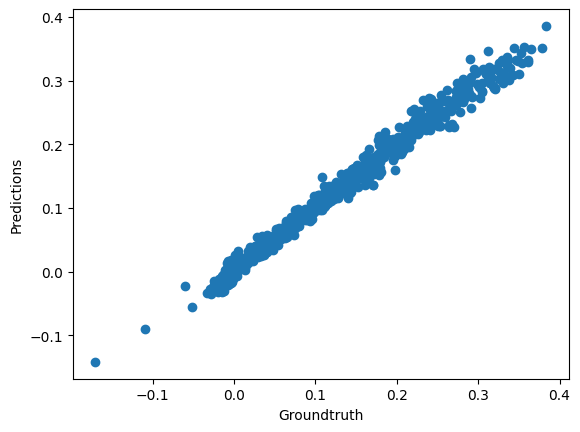

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
for idx, prediction in enumerate(predictions):
    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Groundtruth: [0.025833669298055275]. Predicted: [0.03984852]
Groundtruth: [0.1382970840954399]. Predicted: [0.14225597]
Groundtruth: [0.0030680905040638457]. Predicted: [0.00339523]
Groundtruth: [-0.0017911355336229498]. Predicted: [-0.00398605]
Groundtruth: [0.0016313804724377473]. Predicted: [0.00459905]
Groundtruth: [0.0045914945929491835]. Predicted: [0.00313351]
Groundtruth: [0.026069229179572547]. Predicted: [0.03382637]
Groundtruth: [-0.0008783150244736311]. Predicted: [-0.00490673]
Groundtruth: [0.05635760982513455]. Predicted: [0.05271603]
Groundtruth: [0.3307847093359228]. Predicted: [0.29577541]
Groundtruth: [0.005838566607028711]. Predicted: [0.00610187]
Groundtruth: [-0.012248842107622379]. Predicted: [-0.03018747]
Groundtruth: [0.017496130340990068]. Predicted: [0.01420149]
Groundtruth: [-0.002865841412242513]. Predicted: [-0.00291703]
Groundtruth: [0.07214957481689485]. Predicted: [0.071355]
Groundtruth: [0.0038561463309186982]. Predicted: [0.00245283]
Groundtruth: [-0.0

## Predict CoM -> y

### Linear Regression

In [18]:
# Input
X = np.hstack((X_motion_CoM_acceleration_FR_RL[:, 0:1], # previous reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 3:4], # current reference velocity
               X_motion_CoM_acceleration_FR_RL[:, 6:7], # actual velocity
               X_motion_CoM_acceleration_FR_RL[:, 10:12], # FL position
               X_motion_CoM_acceleration_FR_RL[:, 13:15], # FR position
               X_motion_CoM_acceleration_FR_RL[:, 16:18], # RL position
               X_motion_CoM_acceleration_FR_RL[:, 19:21])) # RR position

# Labels
Y = np.array([Y_motion_CoM_acceleration_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_com_y = find_best_model(X, Y, runs=5000)

R2:  0.7007297815117688
RMSE:  0.003606661658314135
The lowest error is:  2.8267728910949183e-06
The highest error is:  0.012485908774601867
The avg. error is:  0.002739717052965004


In [19]:
model_fr_com_y.coef_

array([[ 0.00139705,  0.00794286, -0.04676512, -0.0122436 ,  0.0483176 ,
        -0.14921831, -0.40602063,  0.09230524, -0.32213948,  0.27410517,
         0.28576526]])

In [20]:
model_fr_com_y.intercept_

array([0.15204344])

Text(0, 0.5, 'Predictions')

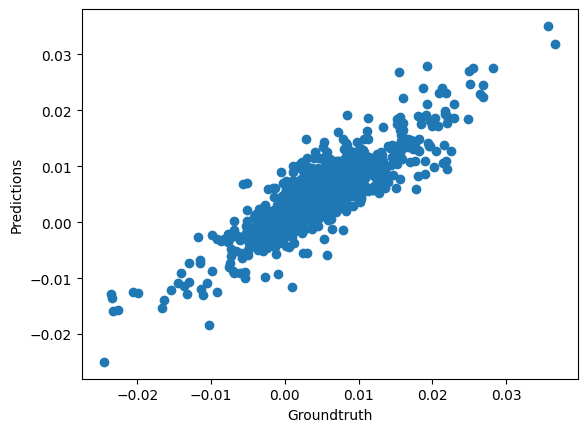

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')